# Preprocessing data for Optuna_AZ


## Introduction
Probably the most important step in using the automated parameter optimization is the preprocessing of the data prior to training the model. Common considerations include how to deal with duplicates SMILES having different read-out values, if and how to split the data into a training and (holdout) test set, and how to prepare input files in a proper way (e.g. transform SDF files into a dataframe with SMILE string- and read-out-columns).

The `Optuna_AZ` packages has some built-in functionality to facilitate that process.

Start with imports.

In [2]:
import pandas as pd
import numpy as np
import random

from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.core.display import display, HTML

from os import listdir
from os.path import isfile, join
from os import walk

# load code from the "Optuna_AZ" package that comes in handy here
#%run ../utils/preprocessing/deduplicator.py
#%run ../utils/preprocessing/splitter.py

In [3]:
# load the plotting libraries, in case needed
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting parameters
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

## Translate from SDF to CSV (if needed)

Optuna_AZ uses SMILES strings (no stereochemistry!) as input molecular representation. Input is a comma-separated values (CSV) file with a SMILES column and a read-out (response) column. Read-out (response) column can be either numeric values (for regression) or labels (for classification). Note, that labels can be in the form of integer values - as long as the optimization process is specified as `classification`, they will be translated into nominal data values.

If the data are available in this form, you may skip this step. Let us assume the data have been provided as molecules with annotated attributes in the SDF format.

In [10]:
file = "../tests/data/D360_CFD_SPR_pKd_more6_all_463cmpds.sdf"
primarydf = PandasTools.LoadSDF(file)

RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 343: MDLV30/STEABS ATOMS=(3 4 5 15) 
[13:03:05] Skipping unrecognized collection type at line 343: MDLV30/STEABS ATOMS=(3 4 5 15) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 344: MDLV30/STERAC1 ATOMS=(1 31) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 2713: MDLV30/STEABS ATOMS=(3 9 11 15) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 2714: MDLV30/STERAC1 ATOMS=(1 18) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 3237: MDLV30/STEABS ATOMS=(3 20 21 26) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 3238: MDLV30/STERAC1 ATOMS=(1 29) 
[13:03:05] Skipping unrecognized collection type at line 344: MDLV30/STERAC1 ATOMS=(1 31) 
[13:03:05] Skipping unrecognized collection type at line 2713: MDLV30/STEABS ATOMS=(3 9 11 15) 
[13:03:05] Skipping unrecognized collection type at line 2714: MDLV

[13:03:05] Skipping unrecognized collection type at line 53387: MDLV30/STERAC3 ATOMS=(1 4) 
[13:03:05] Skipping unrecognized collection type at line 53388: MDLV30/STERAC1 ATOMS=(2 27 28) 
[13:03:05] Skipping unrecognized collection type at line 53755: MDLV30/STEREL1 ATOMS=(1 2) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 54131: MDLV30/STEREL2 ATOMS=(1 16) 
[13:03:05] Skipping unrecognized collection type at line 53756: MDLV30/STERAC1 ATOMS=(1 5) 
[13:03:05] Skipping unrecognized collection type at line 54131: MDLV30/STEREL2 ATOMS=(1 16) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 54132: MDLV30/STEREL1 ATOMS=(1 19) 
[13:03:05] Skipping unrecognized collection type at line 54132: MDLV30/STEREL1 ATOMS=(1 19) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 54321: MDLV30/STEREL2 ATOMS=(1 16) 
RDKit WARNING: [13:03:05] Skipping unrecognized collection type at line 54322: MDLV30/STEREL1 ATOMS=(1 19) 
[13:03:05]

In [12]:
primarydf.head()

,Series,Monoisotopic;Molecular;Weight,Min;Registration;Date,Compound;Name,CFD;Hu Enz FLInt;GMean;pIC50;IT24511;(Mod),CFD;Hu Enz FLInt;GMean;pIC50;IT24511;(Num),CFD;Hu Enz FLInt;GMean;pIC50;IT24511;(Txt),CFD;Hu Bind SPR;GMean;pKd;IT24222;(Mod),CFD;Hu Bind SPR;GMean;pKd;IT24222;(Num),CFD;Hu Bind SPR;GMean;pKd;IT24222;(Txt),...,MDCK-MDR1;ABBA;A to B Papp;(1E-6.cm/s);IT21043;(Mod),MDCK-MDR1;ABBA;A to B Papp;(1E-6.cm/s);IT21043;(Num),MDCK-MDR1;ABBA;A to B Papp;(1E-6.cm/s);IT21043;(Txt),MDCK-MDR1;ABBA;B to A Papp;(1E-6.cm/s);IT21043;(Mod),MDCK-MDR1;ABBA;B to A Papp;(1E-6.cm/s);IT21043;(Num),MDCK-MDR1;ABBA;B to A Papp;(1E-6.cm/s);IT21043;(Txt),MDCK-MDR1;ABBA;Efflux Ratio;IT21043;(Mod),MDCK-MDR1;ABBA;Efflux Ratio;IT21043;(Num),MDCK-MDR1;ABBA;Efflux Ratio;IT21043;(Txt),MDCK-MDR1;ABBA;Efflux Potential;IT21043
0,S2' Amide series,505.212522,23-aug-2019,AZ14195642,=,7.287446257754229,7.3,=,7.631403678647631,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,S2' Amide series,509.2438204,20-sep-2019,AZ14197619,NaN,NaN,NaN,=,6.804220715627383,6.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,S2' Amide series,504.2285056,04-feb-2019,AZ14181886,=,6.143013870864898,6.1,=,6.396431189140873,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,S2' Amide series,575.2155562,11-jun-2019,AZ14191461,=,7.134987957820886,7.1,=,8.108354451592886,8.1,...,=,1.4901561346897481,1.5,=,6.4914032377184968,6.5,=,4.356178673299806,4.4,Likely
4,S2' Amide series,589.2312054,23-jul-2019,AZ14193742,=,7.2628304248308995,7.3,=,8.15762718111699,8.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# get the important columns (activity values and calculated SMILES) and rename them for convenience
# drop the rest
# primarydf["activity"] = primarydf["CFD;Hu Bind SPR;GMean;pKd;IT24222;(Num)"]
primarydf["activity"] = primarydf["CFD;Hu Bind SPR;GMean;pKd;IT24222;(Num)"]
primarydf["smiles"] = [Chem.MolToSmiles(mol, isomericSmiles=False) for mol in primarydf["ROMol"]]
primarydf = primarydf[["smiles", "activity"]]
primarydf.head()

,smiles,activity
0,CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...,7.631403678647631
1,CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...,6.804220715627383
2,CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...,6.396431189140873
3,CC(=O)c1cn(CC(=O)N2CC(F)C3CCC(NC(=O)C(C)(O)C(F...,8.108354451592886
4,CC(=O)c1cn(CC(=O)N2CC(F)C3CCC(NC(=O)C(C)(O)C(F...,8.15762718111699


Note, that there is no need to stick to this column-naming convention - both the preprocessing engine and `Optuna_AZ` allow you to specify the column names to be used explicitly.

## Deal with duplicates

Let's assume you have a proper `pandas` dataframe at this stage, with one column for the molecules as SMILES and one read-out column (numeric activity values in this example). Depending on how you obtained your dataset and whether it is already processed, you might have the same molecule present more than once (duplicates), probably with (hopefully slightly) different values. As these pose a potential problem afterwards, it might be wise to use only unique observations, i.e. remove all instances of duplicated molecules but one. 

There are different strategies to remove duplicates, which will are outlined below.
* `dedup_keep_first()` and `dedup_keep_last()`: keep the first or last occurrence of each duplicate.
* `dedup_keep_random(seed)`: keep a random observation for each duplicate. Note, that the order of observations is not preserved. Use the `seed` parameter to vary results or to reproduce them.
* `dedup_keep_min()` and `dedup_keep_max()`: keep min or max value.
* `dedup_keep_avg()`: take the average for all duplicates.
Each of these methods returns a unique version of the stored dataframe.

In [16]:
import sys
sys.path.append("..")

from optunaz.utils.preprocessing.deduplicator import *

col = "smiles"

df_pos = dedup_keep_first(primarydf, col)
df_rnd = dedup_keep_random(primarydf, col)
df_max = dedup_keep_max(primarydf, col)
df_avg = dedup_keep_avg(primarydf, col)

# print sizes
print(f"ori: {len(primarydf)}, deduplidcated: {len(df_pos)}, {len(df_rnd)}, {len(df_max)}, {len(df_avg)}")

ori: 463, deduplidcated:                                                 smiles           activity
0    CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...  7.631403678647631
1    CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...  6.804220715627383
2    CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...  6.396431189140873
3    CC(=O)c1cn(CC(=O)N2CC(F)C3CCC(NC(=O)C(C)(O)C(F...  8.108354451592886
4    CC(=O)c1cn(CC(=O)N2CC(F)C3CCC(NC(=O)C(C)(O)C(F...   8.15762718111699
..                                                 ...                ...
457  NC(=O)n1cc(NC(=O)N2CC(F)CC2C(=O)NCc2cccc(Cl)c2...  8.153442688392184
458  O=S(=O)(NCc1ccccc1)c1cccc(-c2ccc(-c3cc[nH]n3)s...  6.753523141326646
459  O=C(Nc1cc(Cl)ccc1-c1nnn[nH]1)c1cc(F)cc(C(F)(F)...  6.127453796992728
460  CN1C(=O)C(NC(=O)Cn2cccc(O)c2=O)N=C(c2ccccc2)c2...  6.079682633600124
461                      Cc1nn(-c2ccccc2)c(C)c2cccc1-2  6.668846737850637

[433 rows x 2 columns],                                                 smiles        

To print duplicate, use Pandas DataFrame method `duplicated()` to get indicies of the duplicates.

In [21]:
idx = primarydf.duplicated(subset='smiles')
print(primarydf[idx])

                                                smiles            activity
46   CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...    6.74134288584367
48   CC(=O)c1nn(CC(=O)N2CCC3CCC(NC(=O)C4(F)CC4)C32)...     6.5792495038482
54   [H]C12CCC(NC(=O)C(O)(c3ccccc3)C(F)(F)F)C1([H])...   6.157328624474054
90   O=C(NCc1cccc(Cl)c1F)C1CC(F)CN1C(=O)Cn1nc(C(O)C...   6.502182402701225
163  CC(=O)c1nn(CC(=O)N2CCC(O)CC(NC(=O)CCc3ccc(C(N)...   6.648784731777237
233  CC1CCCC(Nc2ccc(Cl)c(-c3ccc(C(N)=O)c(F)c3)c2)CN...   6.060050837834995
236  CC(=O)c1nn(CC(=O)N2CCCC3C(NC(=O)C4CC4c4ccc(C(N...  6.1298352530312625
239  CC(=O)c1nn(CC(=O)N2CCCC3C(NC(=O)C4CC4c4ccc(C(N...   6.145704577424828
240  NC(=O)c1ccc(C2CC2C(=O)NC2C3CCCN(C(=O)Cn4nc(C(N...   6.349916897321561
252  NC(=O)c1ccc(-c2cc(NC3CN(C(=O)Cn4nc(C(N)=O)c5cc...   7.056754637413759
255  CC(=O)c1nn(CC(=O)N2CCCC3C(NC(=O)C4CC4c4ccc(C(N...   7.897668744125891
256  CC(=O)c1nn(CC(=O)N2CCCC3C(NC(=O)C4CC4c4ccc(C(N...   8.102407705158788
257  NC(=O)c1ccc(C2CC2C(=

### Interlude: Compare the different unification strategies
Depending on the way duplicates are removed, the resulting activity-value distribution is (slightly) different. Both `uniquify_by_position()` and `uniquify_randomly()` are in essence a random selection, while `uniquify_by_value()` will result in the distribution with the highest values (see mean values below).

Note, however, that only few (~40) duplicates were present in the data, so the effect is minimal for this dataset.

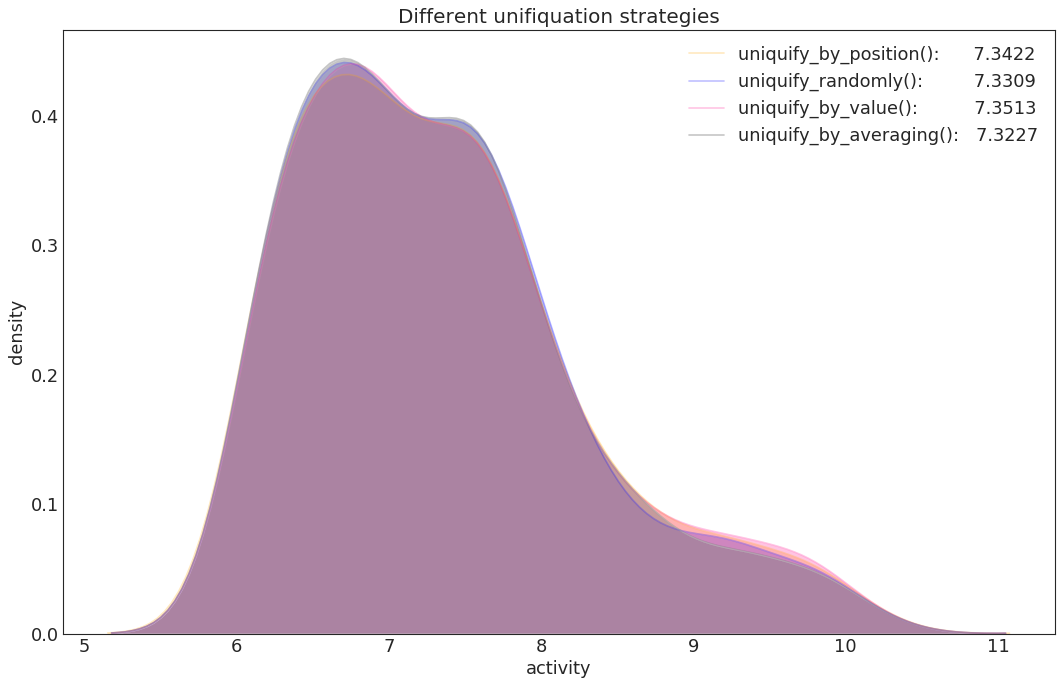

In [8]:
# make a density plot to compare the strategies
plt.figure(figsize=(16,10), dpi=80)

plt.xlabel("activity")
plt.ylabel("density")
plt.title("Different unifiquation strategies", fontsize=18)
sns.kdeplot(df_pos["activity"], shade=True, color="orange", alpha=0.25,
            label = "uniquify_by_position():      %s" % round(df_pos["activity"].mean(), ndigits=4))
sns.kdeplot(df_ran["activity"], shade=True, color="blue", alpha=0.25,
            label ="uniquify_randomly():         %s" % round(df_ran["activity"].mean(), ndigits=4))
sns.kdeplot(df_val["activity"], shade=True, color="deeppink", alpha=0.25,
            label = "uniquify_by_value():          %s" % round(df_val["activity"].mean(), ndigits=4))
sns.kdeplot(df_avg["activity"], shade=True, color="grey", alpha=0.45,
            label = "uniquify_by_averaging():   %s" % round(df_avg["activity"].mean(), ndigits=4))

# do the legend and render
plt.legend(loc="upper right")
plt.show()

For this tutorial, let us consider the de-duplicated result produced by `uniquify_by_value()`.

## Splitting the data

While it recommended to use a hold-out / test set to independently assess your model's performance after the fitting procedure, this step might be skipped, e.g. if your dataset is small and you want to use all observations for training the model. However, usually it would be advisable to separate a hold-out set now (typically about 20% of observations). There are different strategies, depending on your data and aims.

In [22]:
# initialize the splitter
spl = Splitter(dataframe=df_val,
               obsCol="smiles",
               respCol="activity",
               mode="regression")

NameError: name 'Splitter' is not defined

### Random split

It is typically not a good idea to simply take, say, the first 20% of observations and train on the rest. It could very well be, that your data points have some kind of internal ordering such as a temporal dependence. In general, you would want to have your test set to resemble the same (or similar) distribution than the training set.

The easiest way to achieve that is to simply draw observations randomly. This works especially well if you have large datasets, where you can rely on a stochastic behaviour. See example below. Note, that you can use the `seed` parameter to control the initial seed of the random number generator.

In [10]:
# generate a training and test, respectively
train_ran, test_ran = spl.split_randomly(fraction=0.3)

print("Train (random):", len(train_ran))
print("Test (random):", len(test_ran))

Train (random): 294
Test (random): 126


### Temporal split
Sometimes it might be interesting to split the data according to a `time_column`, to e.g. group all old datapoints into the training set and all data points accrued after a specified time into the test set.

For example, if the following 10 values would constitute the `time_column`
```
[1.2, 1.4, 1.9, 1.25, 2.9, 4.5, 1.2, 9.5, 2.3, 3.4]
```
it would be split (with `threshold`=2.3) into
```
training = [1.2, 1.2, 1.25, 1.4, 1.9, 2.3]
test = [2.9, 3.4, 4.5, 9.5]
```
Note, that the value 2.3 would belong to the training set, as the selection is exclusive.

As our test input does not have a specific `time_column`, we will assume that the observations were made with a timestamp recorded, but new observations were added at the top.

In [11]:
# make a copy of the dataframe for illustrative purposes
df_val_temporal = df_val.copy()

# add a "fake" time_column with timestamps
df_val_temporal.insert(2, "timestamp",
                       list(reversed(range(1000, 1000 + len(df_val_temporal)))))
df_val_temporal.head()

,smiles,activity,timestamp
372,CC(=O)c1nn(CC(=O)N2C(C(=O)NCc3cccc(Cl)c3F)CC3C...,10.225867,1419
377,CC(=O)c1cn(CC(=O)N2CC(F)CC2C(=O)Nc2cccc(-c3ccc...,10.168338,1418
376,NC(=O)c1nn(CC(=O)N2CC(F)CC2C(=O)Nc2cccc(-c3ccc...,9.922332,1417
359,NC(=O)c1nn(CC(=O)N2C(C(=O)Nc3cccc(Br)n3)CC3CC3...,9.922332,1416
367,CC(=O)c1nn(CC(=O)N2C(C(=O)Nc3cccc(Br)n3)CC3CC3...,9.903438,1415


In [12]:
# initialize a new splitter with this extended data
spl_temporal = Splitter(dataframe=df_val_temporal,
                        obsCol="smiles",
                        respCol="activity",
                        mode="regression")

# generate a training and test, respectively
# note, that this will generate the 
train_temporal, test_temporal = spl_temporal.split_temporal(time_column="timestamp",
                                                            threshold=1293)

print("Train (temporal):", len(train_temporal))
print("Test (temporal):", len(test_temporal))

Train (temporal): 294
Test (temporal): 126


### Stratified split
Sometimes (especially for small datasets, using only a very small fraction for testing or highly skewed distributions) it might be better to use a *stratified* splitting strategy. Essentially, it will bin the observations according to the value column `respCol` and instead of drawing `fraction` observations from the whole dataset, draw them individually from each bin. This ensures that the distributions of the training and test sets are very close. See example below. Note, that while it is possible to specify a number of bins using parameter `bins`, it is probably better to use the default "fd" (see `numpy.histogram` documentation) which will try to determine a well-balanced number of bins automatically taking the data variability and variance into account.

In [13]:
spl = Splitter(dataframe=df_val,
               obsCol="smiles",
               respCol="activity",
               mode="regression")


# generate a training and test, respectively
train_str, test_str = spl.split_stratified(fraction=0.3)

print("Train (stratified):", len(train_str))
print("Test (stratified):", len(test_str))

Train (stratified): 294
Test (stratified): 126


### Interlude: Compare splitting strategies
The following code will plot the ground distribution for the activity (stored in `df_val`) and the train-test distributions obtained from one of the splitting strategies. This is a good example why caution is in order when using temporal splitting: if the data distributions are different between training and test sets, the resulting model will likely not generalize well to the test set. The random split roughly resembles the ground distribution, but it is evident, that the stratified does an even better job in this respect. For (very) large datasets, the difference between the latter two will likely be less pronounced.

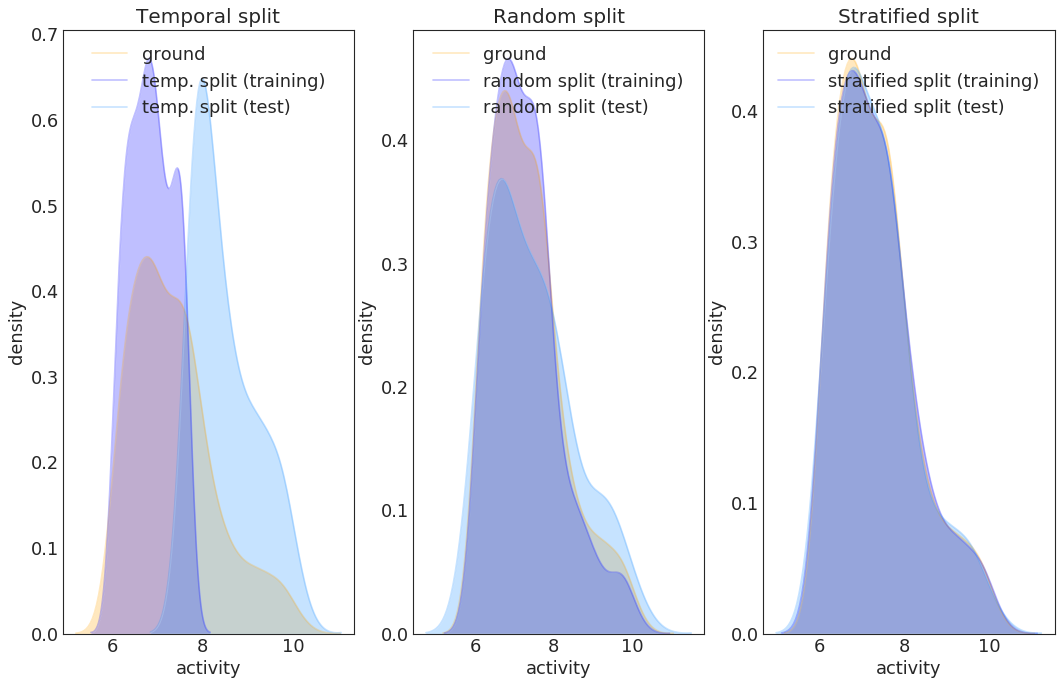

In [14]:
# make a density plot to compare the strategies
plt.figure(figsize=(16,10), dpi=80)

# left plot
plt.subplot(1, 3, 1)
plt.xlabel("activity")
plt.ylabel("density")
plt.title("Temporal split", fontsize=18)
sns.kdeplot(df_val["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(train_temporal["activity"], shade=True, color="blue", label="temp. split (training)", alpha=0.25)
sns.kdeplot(test_temporal["activity"], shade=True, color="dodgerblue", label="temp. split (test)", alpha=0.25)
plt.legend(loc="upper center")

# middle plot
plt.subplot(1, 3, 2)
plt.xlabel("activity")
plt.ylabel("density")
plt.title("Random split", fontsize=18)
sns.kdeplot(df_val["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(train_ran["activity"], shade=True, color="blue", label="random split (training)", alpha=0.25)
sns.kdeplot(test_ran["activity"], shade=True, color="dodgerblue", label="random split (test)", alpha=0.25)
plt.legend(loc="upper center")

# right plot
plt.subplot(1,3,3)
plt.xlabel("activity")
plt.ylabel("density")
plt.title("Stratified split", fontsize=18)
sns.kdeplot(df_val["activity"], shade=True, color="orange", label="ground", alpha=0.25)
sns.kdeplot(train_str["activity"], shade=True, color="blue", label="stratified split (training)", alpha=0.25)
sns.kdeplot(test_str["activity"], shade=True, color="dodgerblue", label="stratified split (test)", alpha=0.25)
plt.legend(loc="upper center")

# do the legend and render
plt.show()

## Save the resulting data sets
Usually, the resulting data frames should be stored as comma-separated values, see below.

In [15]:
train_str.to_csv(path_or_buf="junk/train.csv", index=False)
test_str.to_csv(path_or_buf="junk/test.csv", index=False)